In [2]:
import gym
import os
import sys
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from gym import wrappers
from datetime import datetime
from sklearn.pipeline import FeatureUnion
from sklearn.preprocessing import StandardScaler
from sklearn.kernel_approximation import RBFSampler
from sklearn.linear_model import SGDRegressor
%matplotlib inline

In [12]:
class FeatureTransformer:
    def __init__(self, env, n_components=300):
        observation_examples = np.array([env.observation_space.sample() for x in range(10000)])
        scaler = StandardScaler()
        scaler.fit(observation_examples)
        featurizer = FeatureUnion([
            ("rbf1", RBFSampler(gamma=5.0, n_components=n_components)),
            ("rbf3", RBFSampler(gamma=1.0, n_components=n_components)),
            ("rbf4", RBFSampler(gamma=0.5, n_components=n_components))
            ])

        example_features = featurizer.fit_transform(scaler.transform(observation_examples))
        self.dimensions = example_features.shape[1]
        self.scaler = scaler
        self.featurizer = featurizer


    def transform(self, observations):
        scaled = self.scaler.transform(observations)
        return self.featurizer.transform(scaled)

In [24]:
class Model:
    def __init__(self, env, feature_transformer, learning_rate):
        self.env = env
        self.models = []

        self.feature_transformer = feature_transformer
        for i in range(env.action_space.n):
            model = SGDRegressor(learning_rate=learning_rate,max_iter=5,tol=None)
            model.partial_fit(feature_transformer.transform( [env.reset()] ), [0])
            self.models.append(model)

    def predict(self, s):
        X = self.feature_transformer.transform([s])
        result = np.stack([m.predict(X) for m in self.models]).T
        return result


    def update(self, s, a, G):
        X = self.feature_transformer.transform([s])
        self.models[a].partial_fit(X, [G])


    def sample_action(self, s, eps):
        if np.random.random() < eps:
            return self.env.action_space.sample()
        else:
            return np.argmax(self.predict(s))

In [25]:
def play_episode(model, env, eps, gamma):
    observation = env.reset()
    done = False
    total_reward = 0

    while not done:
        action = model.sample_action(observation, eps)
        prev_observation = observation
        observation, reward, done, info = env.step(action)

        next = model.predict(observation)
        G = reward + gamma*np.max(next[0])
        model.update(prev_observation, action, G)
        total_reward += reward

    return total_reward

In [26]:
def plot_running_avg(total_rewards):
    n = len(total_rewards)
    running_avg = np.empty(n)

    for t in range(n):
        running_avg[t] = total_rewards[max(0, t-100):(t+1)].mean()

    plt.plot(running_avg)
    plt.title("Running Average")
    plt.show()

episode: 0 total reward: -200.0
episode: 100 total reward: -139.0
episode: 200 total reward: -180.0
avg reward for last 100 episodes: -151.78
total steps: -46468.0


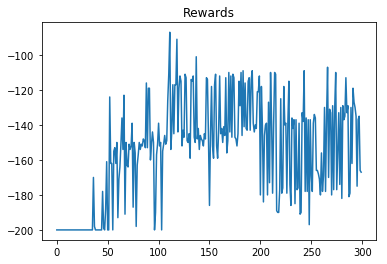

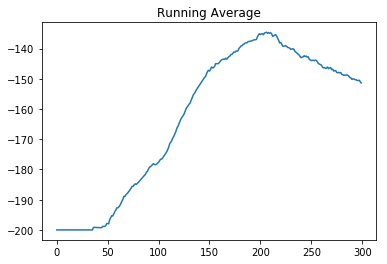

In [28]:
if __name__ == '__main__':
    env = gym.make('MountainCar-v0')
    ft = FeatureTransformer(env)
    model = Model(env, ft, "constant")
    gamma = 0.99

    N = 300
    total_rewards = np.empty(N)
    for n in range(N):
        eps = 1.0/np.sqrt(n+1)
        total_reward = play_episode(model, env, eps, gamma)
        total_rewards[n] = total_reward

        if n % 100 == 0:
            print("episode:", n, "total reward:", total_reward)

    print("avg reward for last 100 episodes:", total_rewards[-100:].mean())
    print("total steps:", total_rewards.sum())

    plt.plot(total_rewards)
    plt.title("Rewards")
    plt.show()

    plot_running_avg(total_rewards)